# Lung and Colon cancer image classification

In [1]:
#Importing openCV and other system libraries

import itertools
import cv2
import os
import time

In [21]:
#Importing tensorflow and analytical libraries (pandas, Numpy, matplotlib)

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Importing required function libraries from tensorflow

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#pip install seaborn

In [4]:
#Importing error metrics to define the performance of a classification algorithm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:

from glob import glob

Data Preparation

In [6]:
#The data present in the dataset is split into multiple folder
#Combining them into a single folder for easier access during analysis

!mkdir ./Lung_Colon
print('Copying files...')
!cp -R /Users/nemisha/Desktop/cancer_image/colon/* ./Lung_Colon
!cp -R /Users/nemisha/Desktop/cancer_image/lung/* ./Lung_Colon
print('All files copied successfully!')

Copying files...
All files copied successfully!


In [7]:
#Collecting all the folder names and image files using glob 

folders = glob('./Lung_Colon' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('./Lung_Colon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['./Lung_Colon/lung_aca', './Lung_Colon/colon_n', './Lung_Colon/colon_aca', './Lung_Colon/lung_n', './Lung_Colon/lung_scc']
Images Count:  500


### Understanding the image dataset

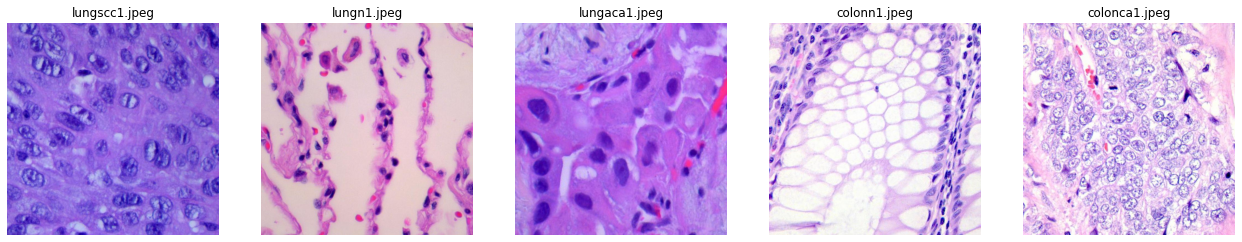

In [8]:
#Analysing the image data 
#Plotting the image data samples to better understand the different cases

SAMPLES = ['./Lung_Colon/lung_scc/lungscc1.jpeg', './Lung_Colon/lung_n/lungn1.jpeg', 
           './Lung_Colon/lung_aca/lungaca1.jpeg', './Lung_Colon/colon_n/colonn1.jpeg', 
           './Lung_Colon/colon_aca/colonca1.jpeg']

plt.figure(figsize=(22, 8)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

### Data Generation

In [9]:
#We use the ImageDataGenerator module from Keras to augument the data we already have
#The function generates new image data to feed into the CNN training data 
# This is done by Translations, Rotations, Shearing, flipping the images etc
# This ensures better training of the neural network

#Specifying the data directoy
data_dir = './Lung_Colon'

#Specifiying 80-20 Split for training and testing
data = ImageDataGenerator(validation_split = 0.2)

#Specifying the batch_size for each iteration
BATCH_SIZE = 128

#Specifying the resolution of the images to be input
# 224 x 224 -- The minimum for EfficientNetB7
#you can go as high as 600 x 600 (which is recommended but very processor heavy hence going for the lower resolution)
X = Y = 224

#Data generation
training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


### Modeling 

#### Tuning and preparing the model parameters

In [10]:
#Specifying the parameters for the input data and expected parameters for the output data

ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)

In [11]:
#Summarising the model prepared

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

#### Running the model fit

In [12]:
#Fitting the model

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    training,
    validation_data=validation,
    epochs=50,
    callbacks=[early_stopping])

Epoch 1/50


2022-08-06 06:31:56.732106: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 124s 34s/step - loss: 1.7083 - accuracy: 0.1925 - val_loss: 1.4271 - val_accuracy: 0.4000
Epoch 2/50
4/4 [==============================] - 98s 31s/step - loss: 1.4049 - accuracy: 0.3775 - val_loss: 1.2274 - val_accuracy: 0.5800
Epoch 3/50
4/4 [==============================] - 99s 24s/step - loss: 1.1241 - accuracy: 0.6375 - val_loss: 1.0005 - val_accuracy: 0.7000
Epoch 4/50
4/4 [==============================] - 102s 25s/step - loss: 0.9164 - accuracy: 0.7200 - val_loss: 0.8332 - val_accuracy: 0.7300
Epoch 5/50
4/4 [==============================] - 98s 24s/step - loss: 0.8194 - accuracy: 0.7500 - val_loss: 0.7600 - val_accuracy: 0.7300
Epoch 6/50
4/4 [==============================] - 97s 24s/step - loss: 0.6776 - accuracy: 0.7600 - val_loss: 0.6450 - val_accuracy: 0.7700
Epoch 7/50
4/4 [==============================] - 96s 24s/step - loss: 0.5601 - accuracy: 0.8175 - val_loss: 0.5640 - val_accuracy: 0.8000
Epoch 8/50
4/4 [====================

## Model results

#### Comparison of Training Accuracy and Loss with test data

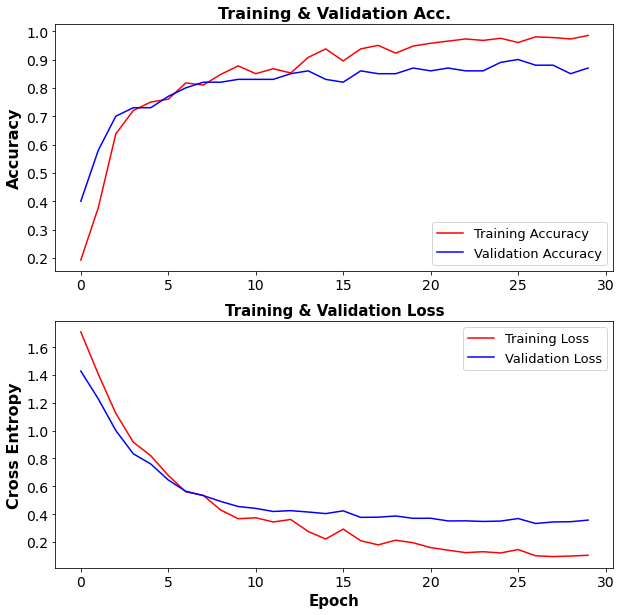

In [13]:
#Plotting the accuracy with the training and test dataset 
#Plotting the loss with the training and test dataset 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

Observations:
    1. As expected, the training accuracy has increased as the number of epochs increases 
    2. After around 10-15 epochs, the accuracy stabilises and we do not see a drastic improvement in the accuracy
    3. The training loss also is observed to be decreasing as the number of epochs increases 
    4. Beyond 10-15 cycles, there is not a significant improvement in the cross entropy 
    5. 10-15 cycles (epochs) seems to be the optimum level for training the data


#### Classification Report for the model

In [14]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.91      1.00      0.95        20
           2       0.75      0.75      0.75        20
           3       1.00      0.95      0.97        20
           4       0.80      0.80      0.80        20

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



#### Observations:
    1. Since we are classifying cancer cases, we would like to reduce false negatives (improper classifications).  So we would like to have a higher value of recall.
    2. Recall is around 0.87 on average but could be improved with a larger dataset
    3. Precision is around 0.87 on a average as well, so this ensures that number of false positives are lower.

#### Confusion Matrix

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

Normalized confusion matrix


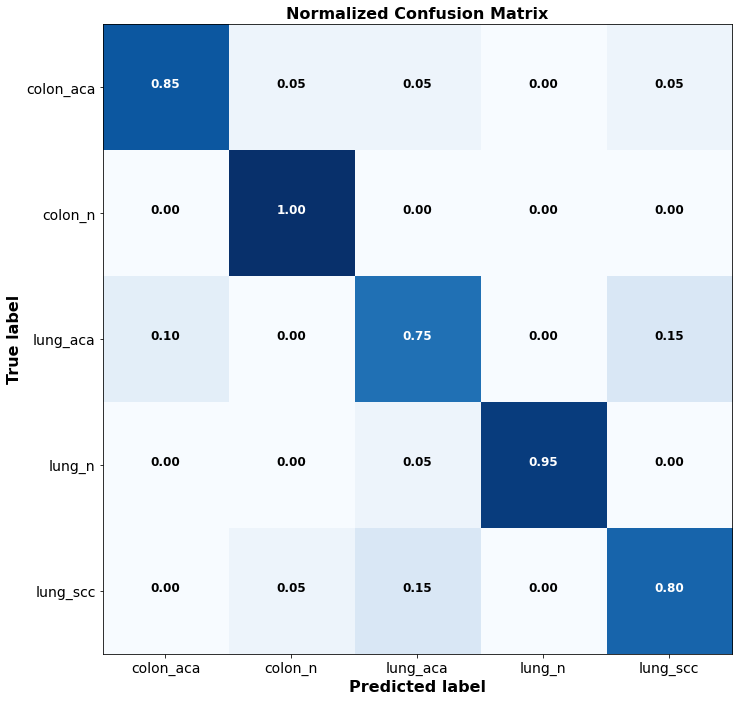

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()

## Best models comparison

In [22]:
#Getting data for other models
#DATA downloaded from <https://mega.nz/folder/pixmTb6b#AS9bXaag9cu5wHHZZVRY-A> for alternate models
! git clone https://github.com/timofeiryko/histopathology-models.git

2022-08-06 12:44:31.429 xcodebuild[11899:549483] Requested but did not find extension point with identifier Xcode.IDEKit.ExtensionSentinelHostApplications for extension Xcode.DebuggerFoundation.AppExtensionHosts.watchOS of plug-in com.apple.dt.IDEWatchSupportCore
2022-08-06 12:44:31.432 xcodebuild[11899:549483] Requested but did not find extension point with identifier Xcode.IDEKit.ExtensionPointIdentifierToBundleIdentifier for extension Xcode.DebuggerFoundation.AppExtensionToBundleIdentifierMap.watchOS of plug-in com.apple.dt.IDEWatchSupportCore
Cloning into 'histopathology-models'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 12), reused 39 (delta 6), pack-reused 0
Receiving objects: 100% (49/49), 418.55 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [12]:
#Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [27]:
#Specifying path

os.chdir(os.path.join('/Users/nemisha/Desktop/histopathology-models'))
model_names = ('ResNet50', 'ResNet50-dropout', 'InceptionV3', 'EfficientNetB7', 'SimpleCNN')
model_paths = (os.path.join(name, f'{name}-log.csv') for name in model_names)

In [23]:
os.listdir('/Users/nemisha/Desktop/histopathology-models')

['ResNet50', 'ResNet50-dropout', 'SimpleCNN', 'EfficientNetB7', 'InceptionV3']

In [28]:
#Collecting log data from other models ran using the same dataset

def collect_logs(model_names: tuple, model_paths: tuple, df: pd.DataFrame = None, sep:str = ';') -> pd.DataFrame:
    for name, path in zip(model_names, model_paths):

            if df is None:
                df = pd.read_csv(path, sep=sep)
                df['model'] = name
                df.set_index(['model', 'epoch'], inplace=True)
                continue
                
            log = pd.read_csv(path, sep=sep)
            log['model'] = name
            log.set_index(['model', 'epoch'], inplace=True)

            df = pd.concat([df, log])

    return df

In [29]:
df = collect_logs(model_names, model_paths)

In [30]:
#Results from other models
df.head()

accuracy      loss  val_accuracy  val_loss
model    epoch                                            
ResNet50 0      0.921750  0.192282      0.971667  0.082222
         1      0.965750  0.087694      0.978333  0.053798
         2      0.975167  0.067033      0.985333  0.043157
         3      0.985417  0.039568      0.982333  0.043396
         4      0.989250  0.026989      0.983000  0.038033

In [31]:
df.shape

(250, 4)

## Observations

#### Comparing accuracies of different models

In [32]:
#Comparing accuracies
print('Final validation accuracy:')
val_acc = df.groupby('model').val_accuracy.max()
val_acc

Final validation accuracy:


model
EfficientNetB7      0.999333
InceptionV3         0.904000
ResNet50            0.996000
ResNet50-dropout    0.994667
SimpleCNN           0.700000
Name: val_accuracy, dtype: float64

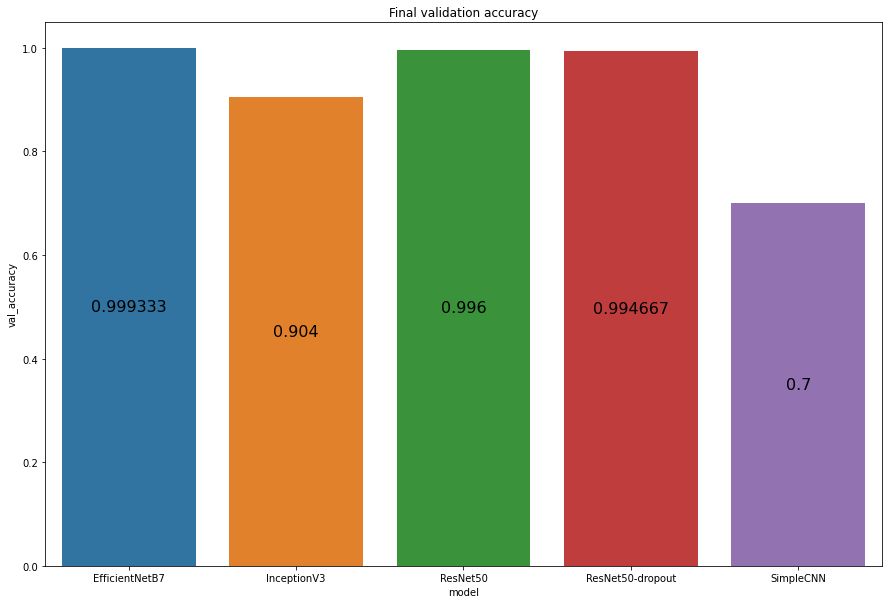

In [33]:
ax = sns.barplot(x=val_acc.index, y=val_acc)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.bar_label(ax.containers[0], size=16,label_type='center')
plt.title('Final validation accuracy')
plt.show()

#### Comparing accuracies of different models against number of cycles

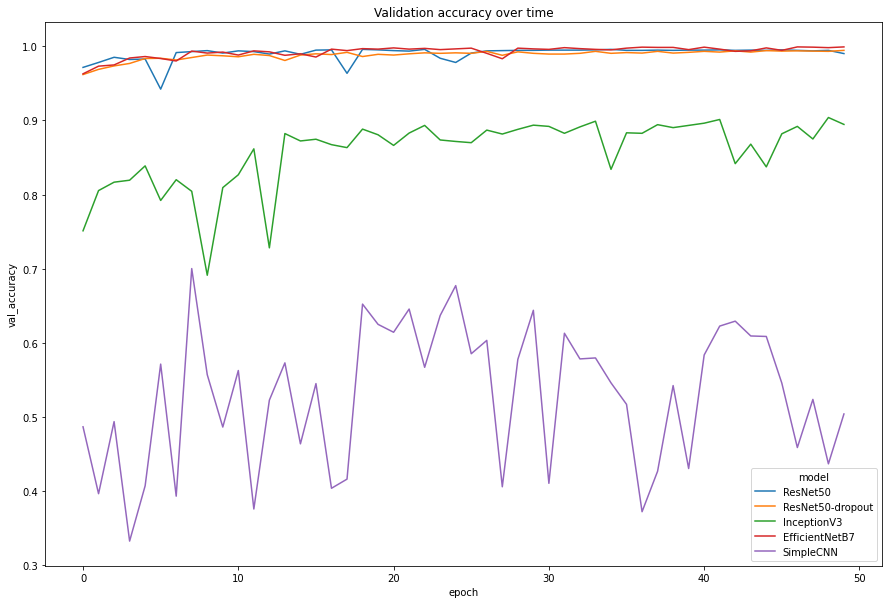

In [34]:
sns.lineplot(data=df, x='epoch', y='val_accuracy', hue='model')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title('Validation accuracy over time')
plt.show()

#### Comparing accuracies of top three models ('ResNet50', 'ResNet50-dropout' and 'EfficientNetB7')

In [35]:
best_list = ('ResNet50', 'ResNet50-dropout', 'EfficientNetB7')
best_df = df.query('model in @best_list')

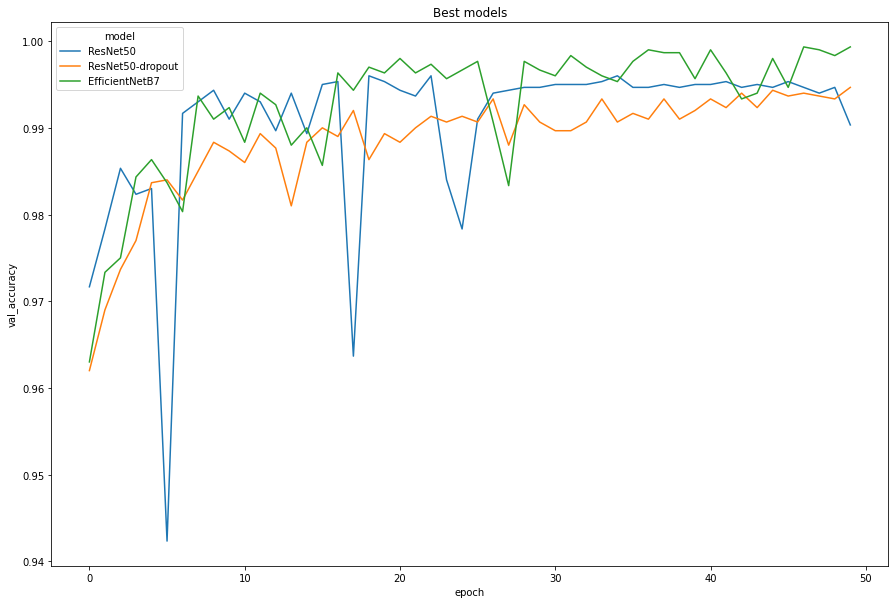

In [36]:
sns.lineplot(data=best_df, x='epoch', y='val_accuracy', hue='model')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title('Best models')
plt.show()

## Observations:
    1. The EfficientNetB7 model provides the best accuracy 99.93%
    2. The accuracy of the model is seen to be improving with number of epochs for all cases
    3. The top three results are from ResNet50 , ResNet50-dropout and EfficientNetB7